In [ ]:
import torch
from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt
import json
import time
import models
import utils

In [2]:
with open('configuration.json') as file:
    configuration = json.load(file)

IMG_HEIGHT = configuration["image"]["heigth"]
IMG_WIDTH = configuration["image"]["width"]
IMG_CHANNELS = configuration["image"]["channels"]
DATA_PATH = configuration["path"]["data_z"]

device = utils.select_device()
model = models.Auto().to(device)
summary(model, input_size=(IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

GPU disponible


Layer (type:depth-idx)                   Output Shape              Param #
Auto                                     [3, 256, 256]             --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [16, 256, 256]            --
│    │    └─Sequential: 3-1              [16, 256, 256]            2,768
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-2                    [16, 128, 128]            --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [32, 128, 128]            --
│    │    └─Sequential: 3-2              [32, 128, 128]            13,888
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-4                    [32, 64, 64]              --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-5                   [64, 64, 6

In [3]:
X = utils.load_images(DATA_PATH=DATA_PATH, getMask = False)
train_loader, validation_loader, test_loader = utils.create_loader(X, X)

imagenes


100%|██████████| 2940/2940 [00:07<00:00, 373.96it/s]


mascaras


In [4]:
model = models.Auto()
model.load_state_dict(torch.load("./models/auto.pth"))
model.to(device)

# Definimos los hiperparámetros
n_epochs = 1000
lr=0.0001
patience = 20 # (vamos a usar early stopping, así que definimos un valor de paciencia)

# Definimos la función de pérdida (error cuadrático medio)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

C:\Users\mauri\AppData\Local\Temp\ipykernel_11460\1100656795.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/auto.pth"))


In [5]:
# Definimos las funciones de entrenamiento y evaluación

def train(model,loader):
    total_loss = 0.0
    for data in loader:
        model.train()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss 


def test(model,loader):
    model.eval()
    total_loss = 0.0
    for data in loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss

In [ ]:
# Entrenamos con early stopping

# Valores iniciales para el early stopping
best_val_loss = 10000.0
best_train_loss = 10000.0
j = 0
epoch = 0
selected_model_state_dict = model.state_dict()

start = time.time()

while ((epoch < n_epochs) and (j < patience)):
    train_loss = train(model, train_loader)
    validation_loss = test(model, validation_loader)
    
    if epoch%10 == 0:
        print('Epoca: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train loss: {:.4f}".format(train_loss), ", Validation loss: {:.4f}".format(validation_loss))
        
    if (validation_loss <= best_val_loss):
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = validation_loss
        selected_model_state_dict = model.state_dict()
        j = 0
    else:
        j += 1

    epoch += 1
        
print('La mejor Epoca fue {:03d}, Train loss: {:.4f}, Validation loss: {:.4f}'.format(
              best_epoch, best_train_loss, best_val_loss))
end = time.time()
elapsed = end-start
print(f"Tiempo de ejecución: {int(elapsed // 3600)} horas, {int((elapsed // 60) % 60)} minutos, {int(elapsed % 60)} segundos")

# Nos quedamos con el modelo con mejor valor de validación  
model.load_state_dict(selected_model_state_dict)

Epoca: 0/1000............. Train loss: 88.9218 , Validation loss: 36.9535
Epoca: 10/1000............. Train loss: 27.0906 , Validation loss: 26.1971
Epoca: 20/1000............. Train loss: 26.7135 , Validation loss: 26.0670
Epoca: 30/1000............. Train loss: 26.6717 , Validation loss: 26.1765
Epoca: 40/1000............. Train loss: 26.1273 , Validation loss: 25.9867
Epoca: 50/1000............. Train loss: 26.1119 , Validation loss: 25.9186
Epoca: 60/1000............. Train loss: 26.0439 , Validation loss: 26.2392
Epoca: 70/1000............. Train loss: 25.4536 , Validation loss: 25.9068
Epoca: 80/1000............. Train loss: 25.2887 , Validation loss: 25.9368
Epoca: 90/1000............. Train loss: 25.0513 , Validation loss: 25.7621
La mejor Epoca fue 077, Train loss: 25.1601, Validation loss: 25.6774


<All keys matched successfully>

In [7]:
torch.save(model.state_dict(), "./models/auto.pth")

In [8]:
model.load_state_dict(torch.load("./models/auto.pth"))

C:\Users\mauri\AppData\Local\Temp\ipykernel_11460\2274416963.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/auto.pth"))


<All keys matched successfully>

In [9]:
model.eval()
idx = 176
input = torch.tensor(X[idx], dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input)

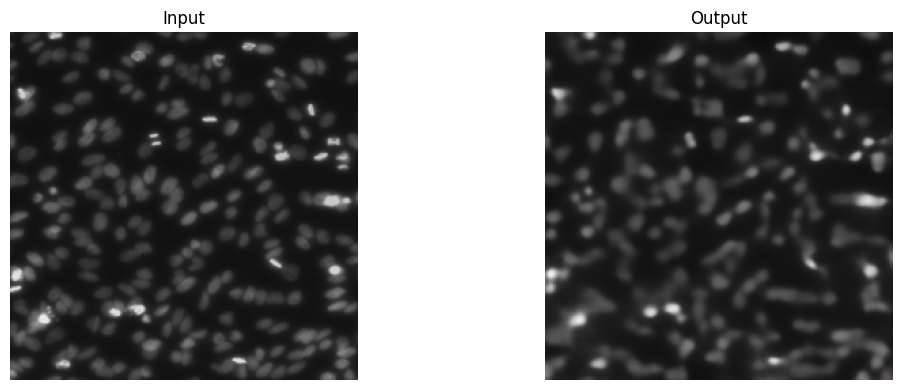

In [10]:
input_image = input.squeeze().permute(1, 2, 0).cpu().numpy()/255
output_image = output.squeeze().permute(1, 2, 0).cpu().numpy()/255

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(input_image)
axs[0].set_title("Input")

axs[1].imshow(output_image)  # Si tienes ground truth
axs[1].set_title("Output")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
a, b = utils.test_similarity(model, zip(X, X))

Dice: 0.9937855533785596
Jaccard: 0.9901212782904217
